In [1]:
import argparse
import logging
from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import GridSplitter, process_folds
import numpy as np
import pyvista as pv

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler("rog_north")
dh.ensure_meshes()

22:41:31 - INFO - Label rog_north already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING']
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

22:41:32 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '8_DOOR', '9_WINDOW', '11_RAILING', '12_RWP', '13_OTHER'].
22:41:32 - INFO - Sampling with resolution 0.15.
22:41:32 - WARNING - Category '1_WALL' not found in meshes.
22:41:32 - WARNING - Category '2_FLOOR' not found in meshes.
22:41:32 - WARNING - Category '3_ROOF' not found in meshes.
22:41:32 - WARNING - Category '4_CEILING' not found in meshes.
22:41:32 - INFO - Number of points after initial sampling: 520125
22:41:32 - INFO - Number of points after Poisson Disk Sampling: 132001
22:41:32 - INFO - Number of points after initial sampling: 42102
22:41:32 - INFO - Number of points after Poisson Disk Sampling: 11823
22:41:32 - INFO - Number of points after initial sampling: 384820
22:41:32 - INFO - Number of points after Poisson Disk Sampling: 10120
22:41:32 - INFO - Number of points after initial sampling: 1197013
22:41:33 - INFO - Number of points after Po

In [5]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

22:41:33 - INFO - Binning is using 12 bins in X and 11 bins in Y based on cell widths of 6.0 and 6.0.


22:41:33 - INFO - New best equality score: 8056599.2854 at iteration 1
22:41:33 - INFO - New best equality score: 6081711.6794 at iteration 13
22:41:33 - INFO - New best equality score: 4060182.6354 at iteration 15
22:41:34 - INFO - New best equality score: 2044349.4436 at iteration 104
22:41:34 - INFO - New best equality score: 2037908.0085 at iteration 282
22:41:35 - INFO - New best equality score: 2032771.6725 at iteration 928
22:41:38 - INFO - New best equality score: 2031954.7078 at iteration 2942
22:41:40 - INFO - New best equality score: 1064302.7544 at iteration 4415
22:41:45 - INFO - New best equality score: 1051906.6923 at iteration 7409
22:41:49 - INFO - 
Best equality score after 10000 iterations: 1051906.6923
22:41:49 - INFO - Best iteration: 7409
22:41:49 - INFO - 
Final category counts per area:

Area 1:
  Area size: 12 cells (9.09% of total, intended 20.00%)
  5_FOOTPATH: 3873 points (2.93% of total 5_FOOTPATH)
  6_GRASS: 3974 points (33.61% of total 6_GRASS)
  8_DOOR: 

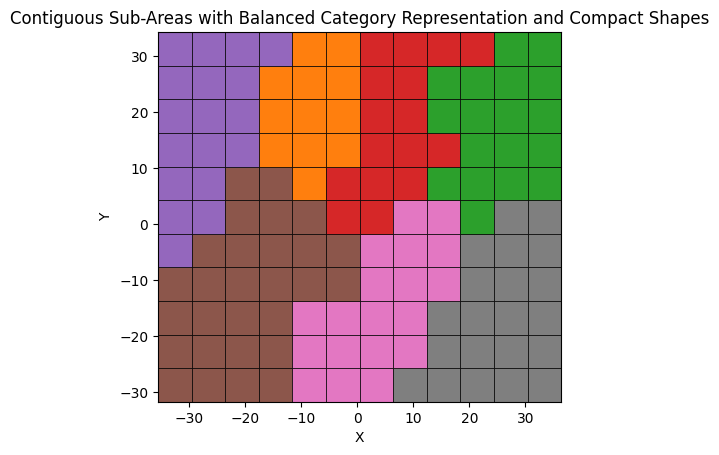

In [6]:
weights = [0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1]  # Intended area weights: training, evaluation, test
iterations = 10000  # Number of iterations to run
min_percentage_threshold = 3  # Minimum acceptable percentage per category per area
verbose = True  # Whether to print detailed statistics

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    min_percentage_threshold=min_percentage_threshold,
    verbose=verbose
)

# Run the algorithm
grid_splitter.run()

# Plot the result
grid_splitter.plot()

In [7]:
best_grid = grid_splitter.best_grid
best_grid

array([[5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7],
       [5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7],
       [5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7],
       [5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7],
       [4, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7],
       [4, 4, 5, 5, 5, 3, 3, 6, 6, 2, 7, 7],
       [4, 4, 5, 5, 1, 3, 3, 3, 2, 2, 2, 2],
       [4, 4, 4, 1, 1, 1, 3, 3, 3, 2, 2, 2],
       [4, 4, 4, 1, 1, 1, 3, 3, 2, 2, 2, 2],
       [4, 4, 4, 1, 1, 1, 3, 3, 2, 2, 2, 2],
       [4, 4, 4, 4, 1, 1, 3, 3, 3, 3, 2, 2]])

In [8]:
x_edges

array([-35.58550262, -29.58550262, -23.58550262, -17.58550262,
       -11.58550262,  -5.58550262,   0.41449738,   6.41449738,
        12.41449738,  18.41449738,  24.41449738,  30.41449738,
        36.41449738])

In [9]:
y_edges

array([-31.75650215, -25.75650215, -19.75650215, -13.75650215,
        -7.75650215,  -1.75650215,   4.24349785,  10.24349785,
        16.24349785,  22.24349785,  28.24349785,  34.24349785])

Processing Fold 1
Fold 1 has 3 rectangles with total perimeter 22.


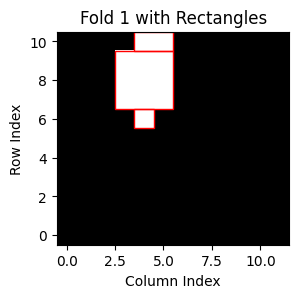

Processing Fold 2
Fold 2 has 5 rectangles with total perimeter 34.


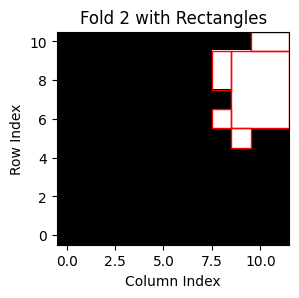

Processing Fold 3
Fold 3 has 5 rectangles with total perimeter 34.


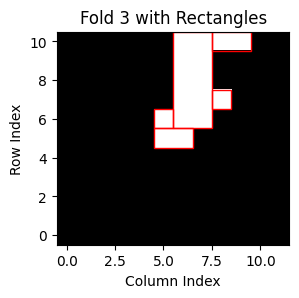

Processing Fold 4
Fold 4 has 4 rectangles with total perimeter 34.


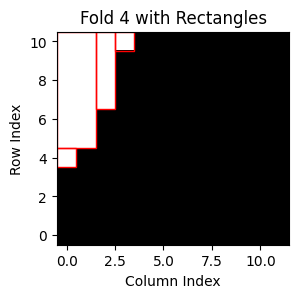

Processing Fold 5
Fold 5 has 6 rectangles with total perimeter 46.


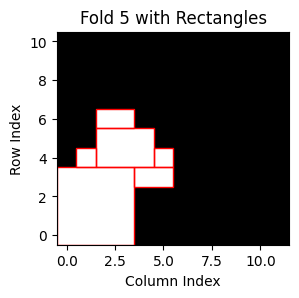

Processing Fold 6
Fold 6 has 4 rectangles with total perimeter 34.


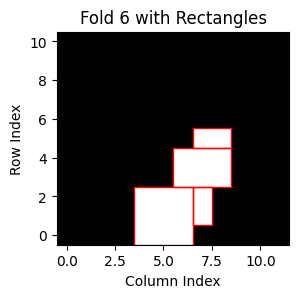

Processing Fold 7
Fold 7 has 4 rectangles with total perimeter 34.


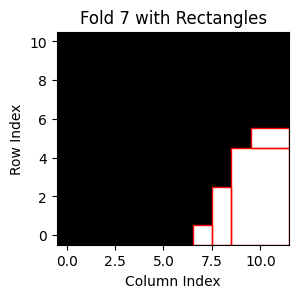

In [10]:
# Process the folds and get the rectangles
fold_rectangles = process_folds(best_grid)

In [ ]:
category_meshes = dh.extracted_meshes

# Now, we proceed with the implementation
def map_grid_to_spatial(min_col, max_col, min_row, max_row, x_edges, y_edges):
    # Map grid indices to spatial coordinates using x_edges and y_edges
    xmin = x_edges[min_col]
    xmax = x_edges[max_col + 1]  # +1 because x_edges has length grid_size_x + 1
    ymin = y_edges[min_row]
    ymax = y_edges[max_row + 1]  # +1 because y_edges has length grid_size_y + 1
    return xmin, xmax, ymin, ymax

# Process each fold and perform cropping operations
fold_meshes = {}

for fold_id, rectangles in fold_rectangles.items():
    print(f"Processing Fold {fold_id}")
    # For each category, we'll create a list to store cropped meshes
    fold_category_meshes = {}
    for category, mesh in category_meshes.items():
        mesh = pv.wrap(mesh)
        # Initialize an empty list to collect cropped meshes for this category and fold
        cropped_meshes = []
        for rect in rectangles:
            # Map grid indices to spatial coordinates
            xmin, xmax, ymin, ymax = map_grid_to_spatial(
                rect['min_col'], rect['max_col'], rect['min_row'], rect['max_row'], x_edges, y_edges)
            
            # Define the cropping box
            # Since PyVista's clip function uses planes, we'll define the planes accordingly
            # We can use the 'extract_box' method for axis-aligned bounding boxes
            bounds = (xmin, xmax, ymin, ymax, mesh.bounds[4], mesh.bounds[5])
            cropped_mesh = mesh.clip_box(bounds, invert=False)
            
            if cropped_mesh.n_points > 0:
                cropped_meshes.append(cropped_mesh)
        
        # Merge the cropped meshes for this category and fold
        if cropped_meshes:
            combined_mesh = cropped_meshes[0]
            for cm in cropped_meshes[1:]:
                combined_mesh = combined_mesh.merge(cm)
            fold_category_meshes[category] = combined_mesh
        else:
            print(f"No mesh data in Fold {fold_id} for category {category}")
    
    # Store the combined meshes per fold
    fold_meshes[fold_id] = fold_category_meshes

Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5
No mesh data in Fold 5 for category 6_GRASS
Processing Fold 6


In [ ]:
import itertools

# Define a list of supported colors (can be expanded with more color names from PyVista)
color_names = [
    "red", "green", "blue", "purple", "cyan", "orange", "yellow",
    "pink", "gold", "teal", "lightblue", "darkblue", "lightgreen", "crimson",
    "coral", "limegreen", "peru", "magenta"
]

# Cycle through colors to handle arbitrary fold IDs
def get_color_for_fold(fold_id):
    """
    Returns a PyVista Color for a given fold ID, cycling through predefined colors.
    """
    color_cycle = itertools.cycle(color_names)  # Cycle through color list
    for _ in range(fold_id):
        color = next(color_cycle)
    return pv.Color(color)
    

pv.set_jupyter_backend('static')
p_static = pv.Plotter()  #off_screen=True)
for fold_id, category_meshes in fold_meshes.items():
    color = get_color_for_fold(fold_id)
    for category, mesh in category_meshes.items():
        p_static.add_mesh(mesh, color=color, show_edges=True, opacity=0.75)
p_static.show_axes_all()
p_static.show_grid(
    font_size=14,
)
p_static.window_size = [1200, 800]
p_static.show()

In [ ]:
logger.info('Completed preprocessing.')